# Exercise: Bayesian parameter estimation

Last revised: 15-Sep-2019 by Christian Forssén [christian.forssen@chalmers.se]

### Import of modules

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

# Not really needed, but nicer plots
import seaborn as sns
sns.set()      
sns.set_context("talk")

## Parameter estimation: fitting a straight line 

Adapted from BayesianAstronomy.
$% Some LaTeX definitions we'll use.
\newcommand{\pr}{\textrm{p}}
$

### The Data

Let's start by creating some data that we will fit with a straight line.  We'll start with a constant standard deviation of $\sigma$ on the $y$ values and no error on $x$.

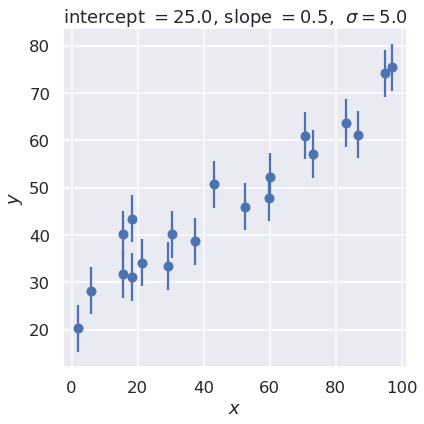

In [2]:
def make_data(intercept, slope, N=20, dy=5, rseed=42):
    """Given a straight line defined by intercept and slope:
          y = slope * x + intercept
       generate N points randomly spaced points from x=0 to x=100
       with Gaussian (i.e., normal) error with mean zero and standard
       deviation dy.
       
       Return the x and y arrays and an array of standard deviations.
    """
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += dy * rand.randn(N)
    return x, y, dy * np.ones_like(x)

intercept = 25.
slope = 0.5
theta_true = [intercept, slope]
x, y, dy = make_data(*theta_true)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, dy, fmt='o')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plot_title = rf'intercept $= {intercept:.1f}$, slope $= {slope:.1f}$, ' \
              + rf' $\sigma = {dy[0]:.1f}$'
ax.set_title(plot_title)
fig.tight_layout()

### The Model

Next we need to specify a model. We're fitting a straight line to data, so we'll need a slope and an intercept; i.e.

$$
y_M(x) = mx + b
$$

where our parameter vector will be 

$$
\theta = [b, m]
$$

But this is only half the picture: what we mean by a "model" in a Bayesian sense is not only this expected value $y_M(x;\theta)$, but a **probability distribution** for our data.
That is, we need an expression to compute the likelihood $\pr(D\mid\theta)$ for our data as a function of the parameters $\theta$.

Here we are given data with simple error bars, which imply that the probability for any *single* data point is a normal distribution about the true value. That is,

$$
y_i \sim \mathcal{N}(y_M(x_i;\theta), \sigma)
$$

or, in other words,

$$
\pr(x_i,y_i\mid\theta) = \frac{1}{\sqrt{2\pi\varepsilon_i^2}} \exp\left(\frac{-\left[y_i - y_M(x_i;\theta)\right]^2}{2\varepsilon_i^2}\right)
$$

where $\varepsilon_i$ are the (known) measurement errors indicated by the error bars.

Assuming all the points are independent, we can find the full likelihood by multiplying the individual likelihoods together:

$$
\pr(D\mid\theta) = \prod_{i=1}^N \pr(x_i,y_i\mid\theta)
$$

For convenience (and also for numerical accuracy) this is often expressed in terms of the log-likelihood:

$$
\log \pr(D\mid\theta) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\varepsilon_i^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\varepsilon_i^2}\right)
$$

###  Exercise

1. *Write a Python function which computes the log-likelihood given a parameter vector $\theta$, an array of errors $\varepsilon$, and an array of $x$ and $y$ values*

2. *Use tools in [``scipy.optimize``](http://docs.scipy.org/doc/scipy/reference/optimize.html) to maximize this likelihood (i.e. minimize the negative log-likelihood). How close is this result to the input ``theta_true`` above?*

In [3]:
def log_likelihood(theta, sigmas, x_data, y_data):
    """
    Returns the log of the probability density of x_data & y_data being observed from
    a linear model y = theta[0] * x**0 + theta[1] * x**1 + ... + error where error is
    a random variable with a normal distribution centered at 0 with variance sigma**2
    """
    assert len(sigmas) == len(x_data) and len(x_data) == len(y_data)

    X_d = np.array([x_data**i for i in range(0,len(theta))]).T #design matrix    
    y_pred = X_d.dot(theta)
    sum = (np.log(2 * np.pi * sigmas**2) + (y_data - y_pred)**2 / sigmas**2).sum()
    return -(1/2) * sum

In [4]:
def obj_fun(theta):
    return -log_likelihood(theta, dy, x, y)

theta_guess = np.array([10, 1])
res = minimize(obj_fun, theta_guess, method='nelder-mead')
print(f"Compare theta_min = {res['x']} \nto      theta_true = {theta_true}")

Compare theta_min = [24.81805301  0.47417263] 
to      theta_true = [25.0, 0.5]


## The Prior

We have computed the likelihood, now we need to think about the prior $\pr(\theta\mid I)$.

This is where Bayesianism gets a bit controversial... what can we actually say about the slope and intercept before we fit our data?

There are several approaches to choosing priors that you'll come across in practice (more on this later):

1. **Conjugate priors.**
A [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) is a prior which, due to its mathematical relation to the likelihood, makes the result analytically computable.

2. **Empirical priors.** 
Empirical Priors are priors which are actually posteriors from previous studies of the same phenomenon. For example, it's common in Supernova cosmology studies to use the WMAP results as a prior: that is, to actually plug-in a *real result* and use the new data to improve on that. This situation is where Bayesian approaches really shine.  For the linear fit, you might imagine that the $x, y$ data is a more accurate version of a previous experiment, where we've found that the intercept is $\theta_0 = 50 \pm 30$ and the slope is $\theta_1 = 1.0 \pm 0.5$.
In this case, we'd encode this prior knowledge in the prior distribution itself.

3. **Flat priors.**
If you don't have an empirical prior, you might be tempted to simply use a *flat prior* – i.e. a prior that is constant between two reasonable limits (i.e. equal probability slopes from -1000 to +1000).  The problem is that flat priors are not always non-informative! For example, a flat prior on the slope will effectively give a higher weight to larger slopes.

4. **Non-informative priors.**
What we *really* want in cases where no empirical prior is available is a **non-informative prior**. Among other things, such a prior should not depend on the units of the data.
Perhaps the most principled approach to choosing non-informative priors was the *principle of maximum entropy* advocated by Jaynes ([book](http://omega.albany.edu:8008/JaynesBook.html)).
Similar in spirit is the commonly-used [Jeffreys Prior](https://en.wikipedia.org/wiki/Jeffreys_prior), which in many cases of interest amounts to a "scale invariant" prior: a flat prior on the logarithm of the parameter.
In the case of the linear slope, we often want a prior which does not artificially over-weight large slopes: there are a couple possible approaches to this (see http://arxiv.org/abs/1411.5018 for some discussion). For our situation, we might use a flat prior on the angle the line makes with the x-axis, which gives
$$
\pr(m) \propto (1 + m^2)^{-3/2}
$$
For lack of a better term, I like to call this a "symmetric prior" on the slope (because it's the same whether we're fitting $y = mx + b$ or $x = m^\prime y + b^\prime$).

### Implementation

Let's define two python functions to compute the options for our prior: we'll use both a (log) flat prior and a (log) symmetric prior.
In general, we need not worry about the normalization of the prior or the likelihood, which makes our lives easier:

In [5]:
def log_flat_prior(theta):
    if np.all(np.abs(theta) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_symmetric_prior(theta):
    if np.abs(theta[0]) < 1000:
        return -1.5 * np.log(1 + theta[1] ** 2)
    else:
        return -np.inf  # log(0)

With these defined, we now have what we need to compute the log posterior as a function of the model parameters.
You might be tempted to maximize this posterior in the same way that we did with the likelihood above, but this is not a Bayesian result! The Bayesian result is a (possibly marginalized) posterior probability for our parameters.
The mode of a probability distribution is perhaps slightly informative, but it is in no way a Bayesian result.

Next you will plot the posterior probability as a function of the slope and intercept.

## Exercise

*Plot the posterior probability distribution for the slope and intercept, once for each prior. You might use ``plt.contourf()`` or ``plt.pcolor()``. How different are the distributions?*

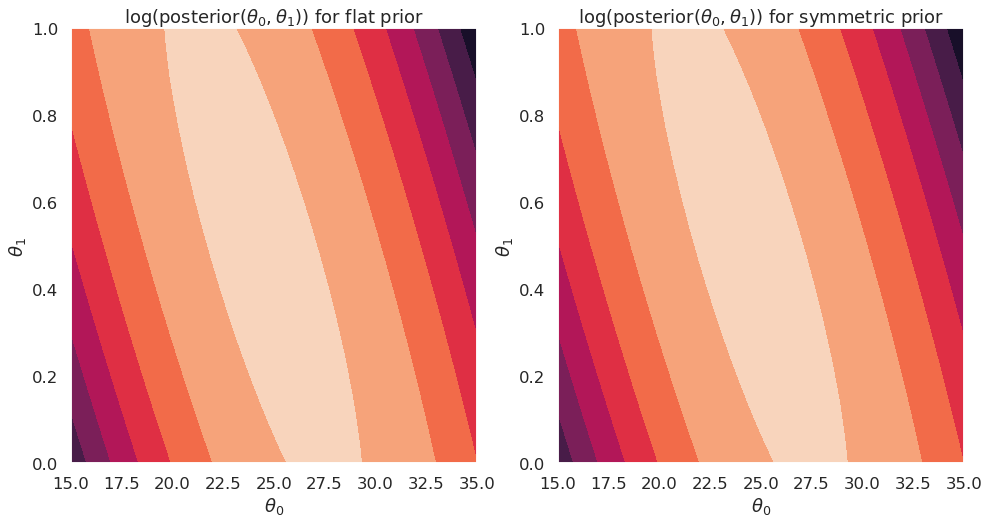

In [6]:
def plot_log_posteriors(x_data, y_data, sigmas):
    
    def log_flat_posterior(theta):
        return log_flat_prior(theta) + log_likelihood(theta, sigmas, x_data, y_data)

    def log_symmetric_posterior(theta):
        return log_symmetric_prior(theta) + log_likelihood(theta, sigmas, x_data, y_data)

    
    theta0_vec = np.linspace(-10,10) + 25
    theta1_vec = np.linspace(-.5,.5) + 0.5
    theta0_grid, theta1_grid = np.meshgrid(theta0_vec, theta1_vec)
    log_flat_posterior_grid = np.zeros_like(theta0_grid) #initiate
    log_symmetric_posterior_grid = np.zeros_like(theta0_grid) #initiate

    ### calculate posterior pdfs ###
    for i, theta0 in enumerate(theta0_vec):
        for j, theta1 in enumerate(theta1_vec):
            log_flat_posterior_grid[i,j] = log_flat_posterior([theta0, theta1])
    for i, theta0 in enumerate(theta0_vec):
        for j, theta1 in enumerate(theta1_vec):
            log_symmetric_posterior_grid[i,j] = log_symmetric_posterior([theta0, theta1])

    ### plot pdf:s ###
    fig, ax = plt.subplots(figsize=(16,8), ncols=2)
    ax[0].contourf(theta0_grid, theta1_grid, log_flat_posterior_grid)
    ax[0].set_xlabel(r'$\theta_0$')
    ax[0].set_ylabel(r'$\theta_1$')
    ax[0].set_title(r'log(posterior($\theta_0, \theta_1$)) for flat prior')

    ax[1].contourf(theta0_grid, theta1_grid, log_symmetric_posterior_grid)
    ax[1].set_xlabel(r'$\theta_0$')
    ax[1].set_ylabel(r'$\theta_1$')
    ax[1].set_title(r'log(posterior($\theta_0, \theta_1$)) for symmetric prior')
    
plot_log_posteriors(x, y, dy)

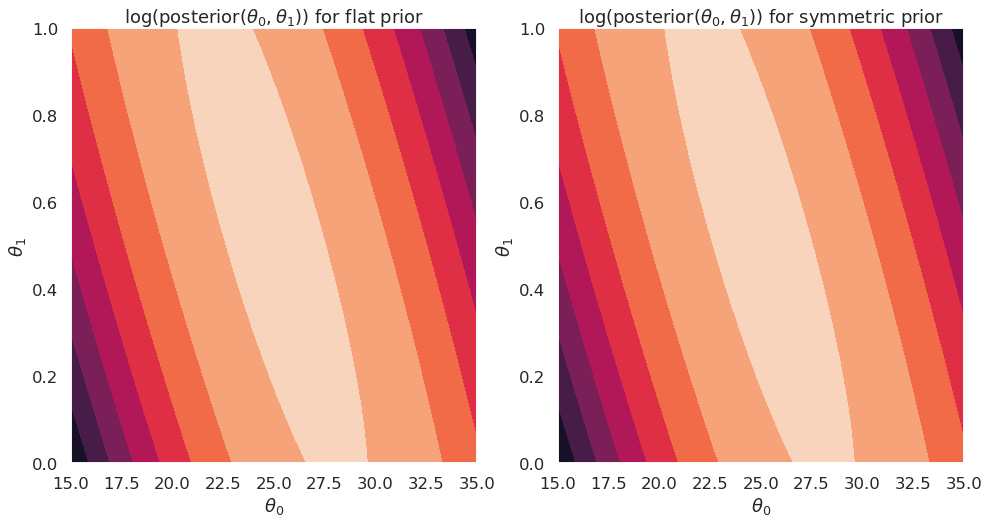

In [11]:
x, y, dy = make_data(*theta_true, N=1000)
plot_log_posteriors(x, y, dy)

You should find that the form of the prior in this case makes very little difference to the final posterior. In general, this often ends up being the case: for all the worrying about the effect of the prior, when you have enough data to constrain your model well, the prior has very little effect.

## Exercise
1. *Modify the dataset – how do the results change if you have very few data points or very large errors?*

2. *If you finish this quickly, try adding 1-sigma and 2-sigma contours to your plot, keeping in mind that the probabilities are not normalized. You can add them to your plot with ``plt.contour()``.*

Let's use a different data with few measurements and see what happens:

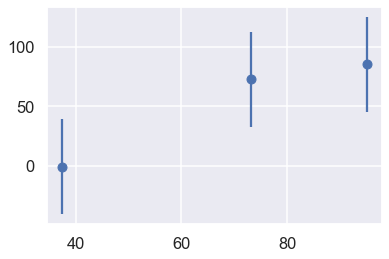

In [12]:
x2, y2, dy2 = make_data(*theta_true, N=3, dy=40)
plt.errorbar(x2, y2, dy2, fmt='o');

### Exercise
*Plot the joint pdf for the slope and the intercept in this case*

In [7]:
# Write your code here

You should find that the form of the prior **does** have a clear effect in the case where the data don't constrain the model well (in this case, three points with very large error bars).
This encodes exactly what you would scientifically expect: if you don't have very good data, it is unlikely to change your views of the world (which are of course encoded in the prior).